In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
#fly = flb.NetFly(1525,rootpath='/media/imager/FlyDataD/FlyDB/')
#fly.open_signals()

In [4]:
flynumbers = list(range(1389,1402))

In [5]:
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]

In [6]:
#l = [fly.open_signals() for fly in flylist]

In [7]:
fly = flylist[4]
fly.open_signals()

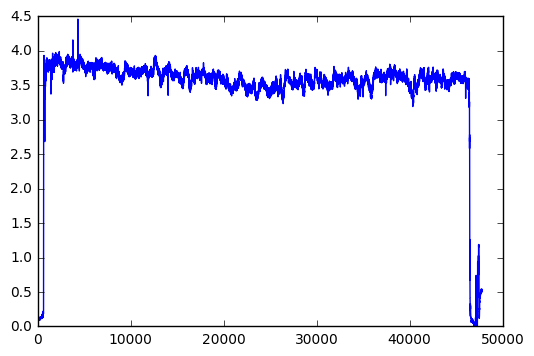

In [9]:
plt.plot(fly.ca_cam_left_model_fits['b1'])

In [14]:
print fly.time[1]

0.0200004184188


In [10]:
resample_rate = 1000 #hz

In [41]:
resampled_left = {}
for key,value in fly.ca_cam_left_model_fits.items():
    resampled_ca,resampled_t = signal.resample(value,
                                           int(fly.time[-1]*2000),np.array(fly.time),
                                            window = 'hanning')
    resampled_left[key] = resampled_ca

resampled_right = {}
for key,value in fly.ca_cam_right_model_fits.items():
    resampled_ca,resampled_t = signal.resample(value,
                                           int(fly.time[-1]*2000),np.array(fly.time),
                                            window = 'hanning')
    resampled_right[key] = resampled_ca

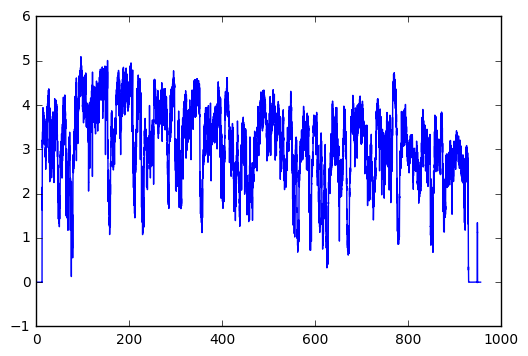

In [42]:
plt.plot(resampled_t,resampled_ca)

In [43]:
resampled_freq,resampled_t = signal.resample(fly.wb_freq,
                                 int(fly.time[-1]*2000),
                                 np.array(fly.time),
                                 window = 'hanning')

In [44]:
#flight_epoch_idx = np.squeeze(np.argwhere(np.squeeze(resampled_freq)>50))
potential_impulse_idxs = list()
#spike_idx = flight_epoch_idx[0]
spike_idx = 1
spike_time = resampled_t[spike_idx]
#while(spike_idx < flight_epoch_idx[-1]):
while(spike_time<resampled_t[-1]):
    spike_idx = np.argwhere(resampled_t<spike_time)[-1][0]
    #print spike_idx
    potential_impulse_idxs.append(spike_idx)
    isi = 1./resampled_freq[spike_idx]
    #print freq_sig[spike_idx]
    #print spike_time
    if (abs(isi) < 0.02):
        #print 'here'
        spike_time += isi
    else:
        spike_time += 0.005

In [45]:
len(potential_impulse_idxs)

206400

In [46]:
len(resampled_t)

1912000

In [47]:
kernel = lpf.

array([ 956.02356018])

In [48]:
resampled_t[-1]

956.01950040795839

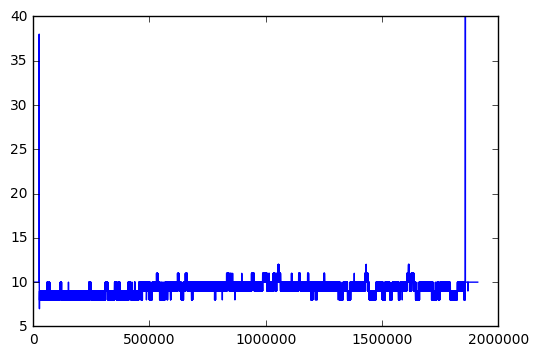

In [50]:
plt.plot(potential_impulse_idxs[:-1],np.diff(potential_impulse_idxs))
#plt.gca().set_xbound(100000,100100)

In [54]:
import local_project_functions as lpf
reload(lpf)

<module 'local_project_functions' from 'local_project_functions.py'>

In [55]:
?lpf.make_single_kernel

Signature: lpf.make_single_kernel(times, tauon1, tauoff1)
Docstring: <no docstring>
File:      /media/imager/FlyDataD/Projects/027_deconvolution/local_project_functions.py
Type:      function


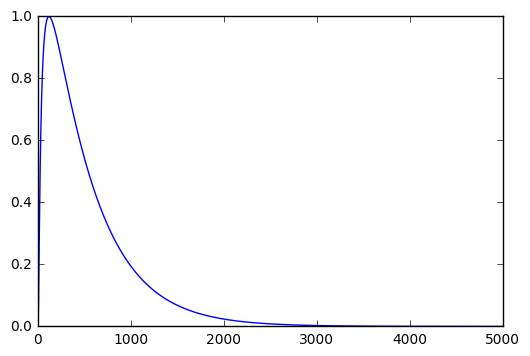

In [69]:
plt.plot(kernel[:5000])

In [56]:
kernel = lpf.make_single_kernel(resampled_t,0.01595905,0.23594343)

local_project_functions.py:13: RuntimeWarning: divide by zero encountered in divide
  kon1 = lambda x:np.exp(((-1*tauon1)/(x)))


In [67]:
print len(resampled_ca)
print len(kernel)

1912000
1912000


In [120]:
decon_left = {}
for key,value in resampled_left.items():
    print key
    decon = lpf.wiener_deconvolution(value,kernel[:5000]*0.1,1.0)
    decon_left[key] = decon

decon_right = {}
for key,value in resampled_right.items():
    decon = lpf.wiener_deconvolution(value,kernel[:5000]*0.1,1.0)
    decon_right[key] = decon

pr
tpd
nm
iii1
iii3
i2
hg2
hg3
hg1
i1
bkg
b1
b2
b3
iii24
hg4


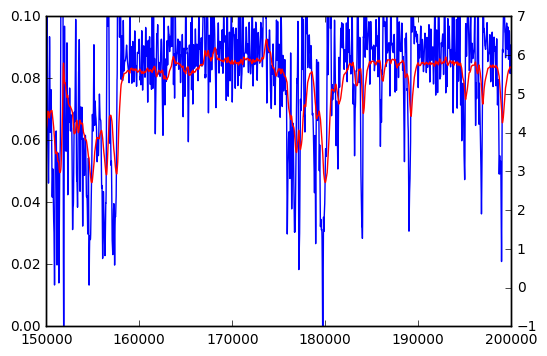

In [130]:
for key in ['iii3']:#'b2','i1','iii3']:#decon_left.items():
    plt.plot(decon_left[key])
plt.gca().set_ybound(0,0.1)
plt.gca().set_xbound(150000,200000)
plt.twinx()
plt.plot(resampled_left['iii3'],color = 'r')
plt.gca().set_xbound(150000,200000)

In [252]:
#thresh = 0.06
spikes_left = {}
for key,value in decon_left.items():
    print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_left[key])[0][1],
                           impulses,
                           recon))
    spikes_left[key] = threshlist
    
spikes_right = {}
for key,value in decon_right.items():
    print key
    threshlist = []
    for thresh in np.linspace(np.percentile(value,5),np.percentile(value,90),10):
        impulses = np.zeros_like(value)
        impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
        recon = scipy.signal.fftconvolve(impulses,kernel)[:len(impulses)]
        threshlist.append((np.corrcoef(recon, resampled_right[key])[0][1],
                          impulses,
                          recon))
    spikes_right[key] = threshlist
    
#spikes_right = {}
#for key,value in decon_right.items():
#    thresh = np.percentile(value,50)
#    impulses = np.zeros_like(value)
#    impulses[potential_impulse_idxs] = (value > thresh)[potential_impulse_idxs]
#    spikes_right[key] = impulses

pr
tpd
nm
iii1
iii3
i2
hg2
hg3
hg1
i1
bkg
b1
b2
b3
iii24
hg4
pr
tpd
nm
iii1
iii3
i2
hg2
hg3
hg1
i1
bkg
b1
b2
b3
iii24
hg4


In [255]:
print np.argmax([item[0] for item in spikes_left['i1']])

9


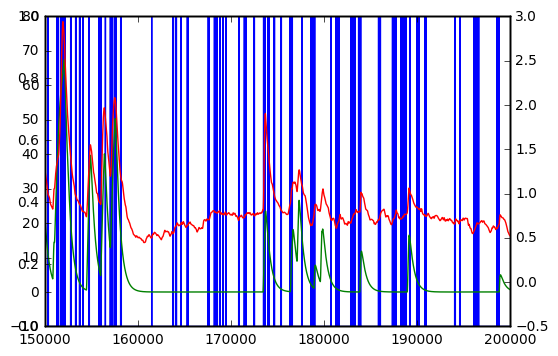

In [257]:
plt.plot(spikes_left['b3'][9][1])
plt.twinx()
plt.plot(spikes_left['i1'][9][2],color = 'g')
plt.twinx()
plt.plot(resampled_left['i1'],color = 'r')
plt.gca().set_xbound(150000,200000)

In [260]:
best_spikes = {}
for key,value in spikes_left.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['left',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}
for key,value in spikes_right.items():
    idx = np.argmax([item[0] for item in value])
    best_spikes['right',key] = {'R':value[idx][0],
                               'spikes':value[idx][1],
                               'reconstruction':value[idx][2]}

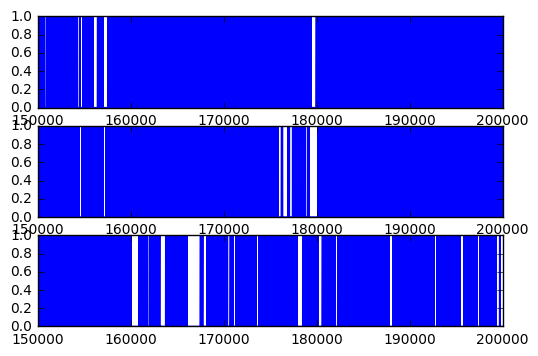

In [273]:
plt.subplot(3,1,1)
plt.plot(best_spikes['left','iii3']['spikes'])
plt.twinx()
plt.plot(best_spikes['left','iii3']['reconstruction'],color = 'r')
plt.gca().set_xbound(150000,200000)
plt.subplot(3,1,2)
plt.plot(best_spikes['right','b3']['spikes'])

plt.twinx()
plt.plot(best_spikes['left','iii3']['reconstruction'],color = 'r')
plt.gca().set_xbound(150000,200000)
plt.subplot(3,1,3)
plt.plot(best_spikes['right','iii3']['spikes'])
plt.gca().set_xbound(150000,200000)
plt.twinx()
plt.plot(best_spikes['left','iii3']['reconstruction'],color = 'r')
plt.gca().set_xbound(150000,200000)